In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt




ResNet_KAN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), pa

# Create the CNN MLP+KAN Hybrid Model

In [22]:
class NaiveFourierKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, initial_gridsize, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim
        self.gridsize_param = nn.Parameter(torch.tensor(initial_gridsize, dtype=torch.float32)) #adjusted during training
        self.fouriercoeffs = nn.Parameter(torch.empty(2, outdim, inputdim, initial_gridsize))
        nn.init.xavier_uniform_(self.fouriercoeffs)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, outdim))
            nn.init.kaiming_normal_(self.bias)
        nn.BatchNorm1d(inputdim)

    def forward(self, x): #Combines cosine/sine terms with learnable coefficents for Fourier expansion and sums them + bias
        gridsize = torch.clamp(self.gridsize_param, min=1).round().int()
        outshape = x.shape[:-1] + (self.outdim,)
        x = torch.reshape(x, (-1, self.inputdim))
        k = torch.reshape(torch.arange(1, gridsize + 1, device=x.device), (1, 1, 1, gridsize))
        xrshp = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        c = torch.cos(k * xrshp)
        s = torch.sin(k * xrshp)
        y = torch.sum(c * self.fouriercoeffs[0:1, :, :, :gridsize], (-2, -1))
        y += torch.sum(s * self.fouriercoeffs[1:2, :, :, :gridsize], (-2, -1))
        if self.addbias:
            y += self.bias
        y = torch.reshape(y, outshape)
        return y

class Block(nn.Module):
    expansion: int = 2
    def __init__(self, input, output, identity_downsample=None, stride=(1,1)):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=(3,3), stride=(1,1), padding=1)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output, output*self.expansion, 
                               kernel_size=(3,3), stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(output*self.expansion,)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x = x + identity
        x = self.relu(x)
        return x
    
class ResNet_KAN(nn.Module):
    def __init__(self, block: Block, layers, input_shape, output_shape):
        super(ResNet_KAN, self).__init__()
        self.input = 16
        self.conv1 = nn.Conv2d(input_shape, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(1,1), padding=(1,1))

        ###ResNet Layers
        self.layer1 = self.make_layer(block,layers[0], output=16, stride=(2,2))
        self.layer2 = self.make_layer(block,layers[1], output=32, stride=(2,2))

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.KANClassifier = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(32*block.expansion, 128), 
            nn.ReLU(),
            NaiveFourierKANLayer(128, 128, initial_gridsize=20),
            nn.Linear(128, output_shape)
        )
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)

        x = self.KANClassifier(x)
        return x
    
    def make_layer(self, block, num_residual_MyBlocks, output, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.input != output*block.expansion:
            identity_downsample = nn.Sequential(nn.Conv2d(
                self.input, output * block.expansion, kernel_size=(1,1), stride=stride),
                nn.BatchNorm2d(output*block.expansion)
            )
        layers.append(block(self.input, output, identity_downsample, stride))
        self.input = output*block.expansion

        for _ in range(num_residual_MyBlocks-1):
            layers.append(block(self.input, output))
        
        return nn.Sequential(*layers)



torch.manual_seed(23)
fsl_model = ResNet_KAN(Block, [2,2,2], input_shape=1, 
                       output_shape=10)
print(f"{fsl_model}")


# Count the total number of parameters
total_params = sum(p.numel() for p in fsl_model.parameters())
print(f"Total number of parameters: {total_params}")

ResNet_KAN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), pa

In [23]:
device = "cpu"

## Dummy Data Testing

In [24]:

tensor1 = torch.randn(size=(1, 28, 28))  # Single image (C, H, W)
print(tensor1.shape)  # Should print torch.Size([3, 128, 128])

output = fsl_model(tensor1.unsqueeze(dim=0))  # Add batch dimension
print(output)



torch.Size([1, 28, 28])
tensor([[ 0.0299,  0.1907, -0.0560, -0.0424, -0.0755, -0.0775,  0.1182,  0.0021,
          0.0123,  0.0729]], grad_fn=<AddmmBackward0>)


# Create Training Loop

In [ ]:
def train(data_loader:torch.utils.data.DataLoader,
               model:torch.nn.Module,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               calculate_accuracy,
               device: torch.device = device,
               loss_steps: int = 100,
               seed: int = 25):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Training
  train_loss, train_acc = 0, 0
  #Put Data into training Mode
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += calculate_accuracy(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) #from logits -> prediction labels
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)
  if epoch % loss_steps == 0:
    print(f"Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.4f}%")
  return train_loss, train_acc

def test(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              calculate_accuracy,
              device: torch.device = device,
              loss_steps: int = 100,
              seed: int = 42):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Testing
  test_loss, test_acc = 0, 0
  model.to(device)
  #Put Data into evaluation Mode
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X,y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_acc += calculate_accuracy(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    if epoch % loss_steps == 0:
      print(f"Test Loss {test_loss:.5f} | Test Accuracy {test_acc:5f}%")
    return test_loss, test_acc

# Import, Preprocess and Load the Data

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),
])

train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_train, download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=transform_test, download=True)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define Loss, Accuracy and other Parameters

In [ ]:
loss_fn = nn.CrossEntropyLoss()
num_of_epochs = 10
num_loss_steps = 1
seed_number = 42
learning_rate = 0.001

#Define Accuracy Metric
def calculate_accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  accuracy = (correct / len(y_pred)) * 100
  return accuracy

# Train the Model

In [ ]:
import time
from tqdm.auto import tqdm

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

model_Adam = ResNet_KAN(Block, [2,2,2], input_shape=1, output_shape=len(train_data.classes))
model_Adam
optimizer_Adam= torch.optim.Adam(params=model_Adam.parameters(), 
                                 lr=learning_rate, 
                                 betas=(0.9, 0.99), 
                                 weight_decay=1e-3)

results3 = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_epoch = 0
epoch = num_of_epochs
loss_steps = num_loss_steps 
start_adam = time.perf_counter()
for epoch in tqdm(range(start_epoch, num_of_epochs)):
  if epoch % loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss3, train_accu3 = train(data_loader = train_dataloader,
                                    model = model_Adam,
                                    loss_fn = loss_fn,
                                    optimizer = optimizer_Adam,
                                    calculate_accuracy = calculate_accuracy,
                                    device = device,
                                    loss_steps = loss_steps,
                                    seed = seed);

  test_loss3, test_accu3 = test(data_loader = test_dataloader,
                                     model = model_Adam,
                                     loss_fn = loss_fn,
                                     calculate_accuracy = calculate_accuracy,
                                     device = device,
                                     loss_steps = loss_steps,
                                     seed=seed)

  results3["train_loss"].append(train_loss3)
  results3["train_accu"].append(train_accu3)
  results3["test_loss"].append(test_loss3)
  results3["test_accu"].append(test_accu3)
end_adam = time.perf_counter()
total_time_adam = end_adam - start_adam
print(f"Total Runtime: {total_time_adam}")



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 


/home/aries/miniconda3/envs/Aries/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Training Loss: 0.33157 | Training Accuracy: 90.2002%
Test Loss 0.18725 | Test Accuracy 94.367038%
Epoch: 1 
Training Loss: 0.10209 | Training Accuracy: 97.1748%
Test Loss 0.08654 | Test Accuracy 97.551752%
Epoch: 2 
Training Loss: 0.08247 | Training Accuracy: 97.7046%
Test Loss 0.09682 | Test Accuracy 97.342755%
Epoch: 3 
Training Loss: 0.07170 | Training Accuracy: 97.9927%
Test Loss 0.08104 | Test Accuracy 97.919984%
Epoch: 4 
Training Loss: 0.06646 | Training Accuracy: 98.1410%
Test Loss 0.06649 | Test Accuracy 98.109076%
Epoch: 5 
Training Loss: 0.06266 | Training Accuracy: 98.2659%
Test Loss 0.10419 | Test Accuracy 96.994427%
Epoch: 6 
Training Loss: 0.05644 | Training Accuracy: 98.4542%
Test Loss 0.05109 | Test Accuracy 98.437500%
Epoch: 7 
Training Loss: 0.05345 | Training Accuracy: 98.4408%
Test Loss 0.04668 | Test Accuracy 98.736067%
Epoch: 8 
Training Loss: 0.05150 | Training Accuracy: 98.5508%
Test Loss 0.05600 | Test Accuracy 98.517118%
Epoch: 9 
Training Loss: 0.04794 | Tra

# Evaluation

## Plot the Loss Curves

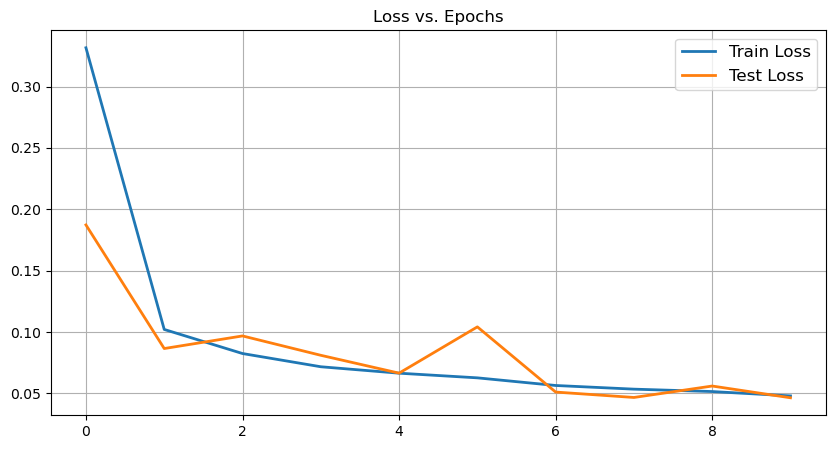

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(results3["train_loss"], linewidth = 2.0, label="Train Loss")
plt.plot(results3["test_loss"], linewidth = 2.0, label="Test Loss")
plt.legend(fontsize=12)
plt.title("Loss vs. Epochs")
plt.grid(True)
plt.show()

## Visualize Confusion Matrix

### Define the tools needed

In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score

from torchmetrics.classification import ConfusionMatrix
from torchmetrics.functional import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

def infer(data_loader:torch.utils.data.DataLoader,
           model:torch.nn.Module,
           test_data):
    '''
    Make an inference from the trained model on the Test/Unseen Dataset
    '''
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Send the data to the proper target device
            X, y = X.to(device), y.to(device)
            # Forward pass
            y_logit = model(X)
            # Turn predictions into class labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            # Put predictions on CPU for evaluation
            y_preds.append(y_pred.cpu())

    # Concatenate list of predictions into a tensor
    y_preds = torch.cat(y_preds)  # This line ensures y_preds is a tensor

    # Ensure test_data.targets is a tensor
    test_targets_tensor = torch.tensor(test_data.targets) if not isinstance(test_data.targets, torch.Tensor) else test_data.targets
    return test_targets_tensor, y_preds

def calculate_metric(y_true, y_pred, average="weighted"): ##--> Choose 'micro', 'macro', or 'weighted'
   
    '''
    Calculate Metric scores of the trained model for f1, precision, and recall 
    '''
     # Convert logits to predicted class labels if necessary
    if y_pred.dim() > 1:
        y_pred = torch.argmax(y_pred, dim=1)

    # Move to CPU and convert to numpy arrays if necessary
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average=average)  
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    
    return f1, precision, recall

def create_confusion_matrix(y_true, y_pred, class_names, num_classes=None, figsize=(19, 10)):
    '''
    This function is to be used for generating confusion matrix 
    '''

    if num_classes is None:
        num_classes = len(class_names)
    
    # Create confusion matrix instance
    confmat = ConfusionMatrix(num_classes=num_classes, task="multiclass")
    confmat_tensor = confmat(preds=y_pred, target=y_true)
    
    # Plot confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=figsize
    )
    plt.show()


### Show the Metric

  0%|          | 0/157 [00:00<?, ?it/s]

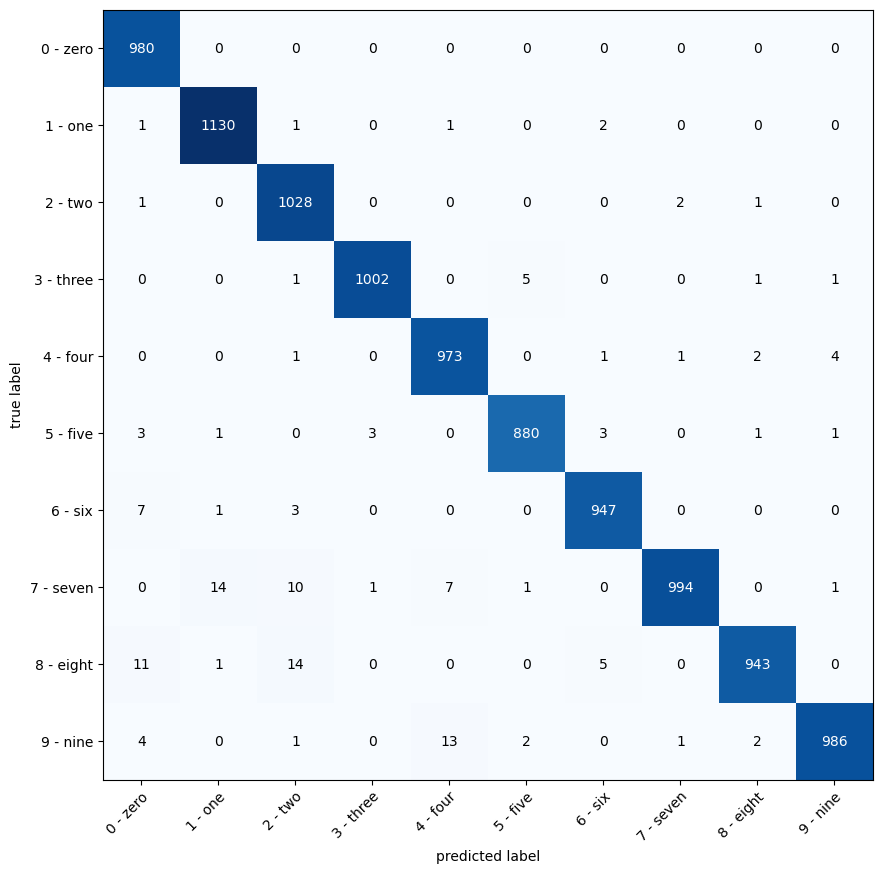

Print F1 score: 0.9862885742349703
Precision Score: 0.9864483864424523
Recall Score: 0.9863


In [30]:
test_targets1, y_preds1 = infer(test_dataloader, model_Adam, test_data)
create_confusion_matrix(test_targets1, y_preds1, class_names=train_data.classes)
f1_score1, precision_score1, recall_score1 = calculate_metric(test_targets1.cpu(), y_preds1)
print(f"Print F1 score: {f1_score1}")
print(f"Precision Score: {precision_score1}")
print(f"Recall Score: {recall_score1}")

In [31]:
import random

def make_predictions(
    model: torch.nn.Module,
    data: list,
    device: torch.device = device
    ):
  pred_probs = [];
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)

test_samples = []; test_labels = [];
for sample, label in random.sample(list(test_data), k=17):
  test_samples.append(sample)
  test_labels.append(label)

pred_probs = make_predictions(model = model_Adam,
                              data = test_samples)
pred_classes = pred_probs.argmax(dim=1)

## Visualize Sample Predictions

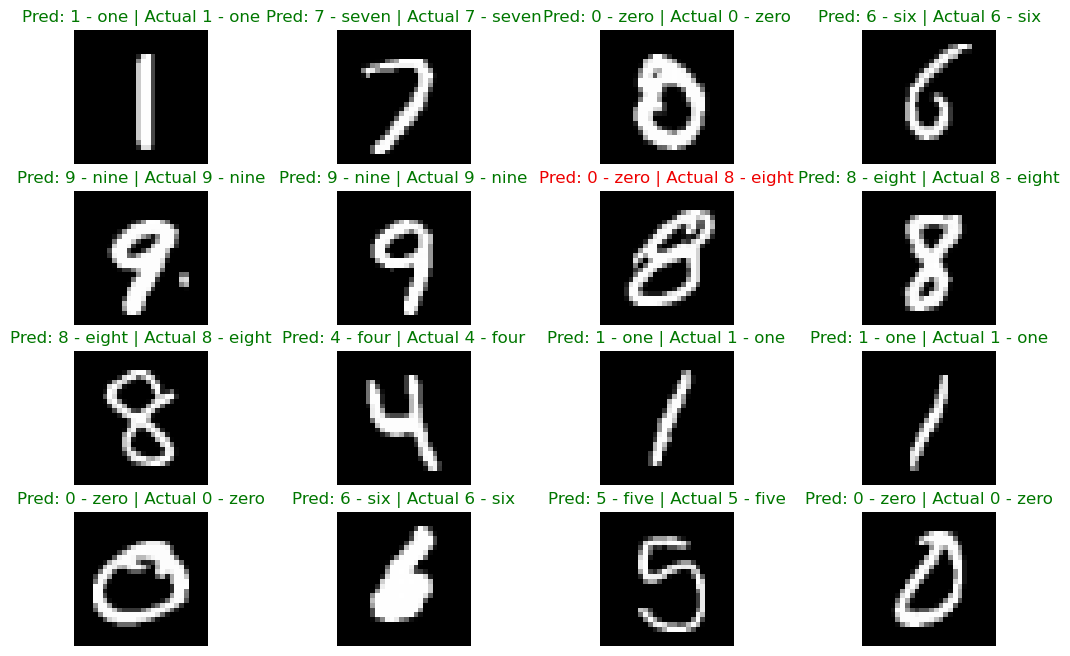

In [35]:
plt.figure(figsize=(13,8))
rows = 4
cols = 4
for i, sample in enumerate(test_samples[: rows*cols]):
  plt.subplot(rows, cols, i+1)
  # plt.imshow(sample.squeeze().permute(1, 2, 0))
  plt.imshow(sample.squeeze(), cmap='gray') 
  #Find the prediction labels
  pred_label = train_data.classes[pred_classes[i]]
  #Get the true labels
  truth_label = test_data.classes[test_labels[i]]

  #Create the title text of the plot
  title_text = f"Pred: {pred_label} | Actual {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, color="#007700")
  else:
    plt.title(title_text, color="#EE0000")
  plt.grid(True)
  plt.axis(False)